# Cuaderno para realizar la exploracion en la busqueda de la homogeneizacion de las series

Partimos de utilizar los datos proporcionados por la pagina del [National Weather Service](http://www.nws.noaa.gov/) de los estados unidos, donde descargamos los datos del ONI(Oceanic Nino Index), de esta forma obtenemos los periodos donde han ocurrido los fenomenos del niño y de la niña.

[Cold & Warm Episodes by Season](https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php)

In [5]:
import pandas as pd

columns = ['Year', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
oni = pd.read_csv("../RecursosYDocumentos/ONI/ONI.csv", header=None, delimiter="\t", names=columns)
print(oni.head(5))
oni = oni.melt(id_vars=["Year"], var_name="month", value_name="oni")
oni["month_number"] = pd.to_datetime(oni["month"], format='%B').dt.month
oni = oni.sort_values(by=["Year", "month_number"])
oni.reset_index(drop=True, inplace=True)

oni["nino"] = oni["oni"] > 0.5
oni["nina"] = oni["oni"] < -0.5

oni = oni.astype({"nino": int, "nina": int})

print(oni.head(5))

   Year  January  February  March  April  May  June  July  August  September  \
0  1950     -1.5      -1.3   -1.2   -1.2 -1.1  -0.9  -0.5    -0.4       -0.4   
1  1951     -0.8      -0.5   -0.2    0.2  0.4   0.6   0.7     0.9        1.0   
2  1952      0.5       0.4    0.3    0.3  0.2   0.0  -0.1     0.0        0.2   
3  1953      0.4       0.6    0.6    0.7  0.8   0.8   0.7     0.7        0.8   
4  1954      0.8       0.5    0.0   -0.4 -0.5  -0.5  -0.6    -0.8       -0.9   

   October  November  December  
0     -0.4      -0.6      -0.8  
1      1.2       1.0       0.8  
2      0.1       0.0       0.1  
3      0.8       0.8       0.8  
4     -0.8      -0.7      -0.7  
   Year     month  oni  month_number  nino  nina
0  1950   January -1.5             1     0     1
1  1950  February -1.3             2     0     1
2  1950     March -1.2             3     0     1
3  1950     April -1.2             4     0     1
4  1950       May -1.1             5     0     1


In [43]:
import matplotlib.pyplot as plt
import shutil
import json
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

lista_zonas = ['MAGDALENA_MEDIO']
path = '../datos/imputados_SARIMA/'


Zona: MAGDALENA_MEDIO
Estacion: 23020100 Vecinas: [23025040]
Estación: 23020100 - Vecinas: [23025040]
Punto de cambio no coincide con fenomeno del niño o la niña:
Estación: 23020100 - Vecina: 23025040
          Mes  Punto de Cambio  Estadística de Worsley  Year      month  oni  \
0     January             2004              319.314567  2004    January  0.4   
1    February             2007              427.862605  2007   February  0.2   
3       April             2006              106.006304  2006      April -0.4   
4         May             2018              209.104648  2018        May -0.2   
5        June             2013              124.622439  2013       June -0.4   
6        July             2011              205.678949  2011       July -0.5   
7      August             2013              210.716344  2013     August -0.3   
8   September             2000              266.308292  2000  September -0.5   
11   December             2012              290.488638  2012   December -0.2   

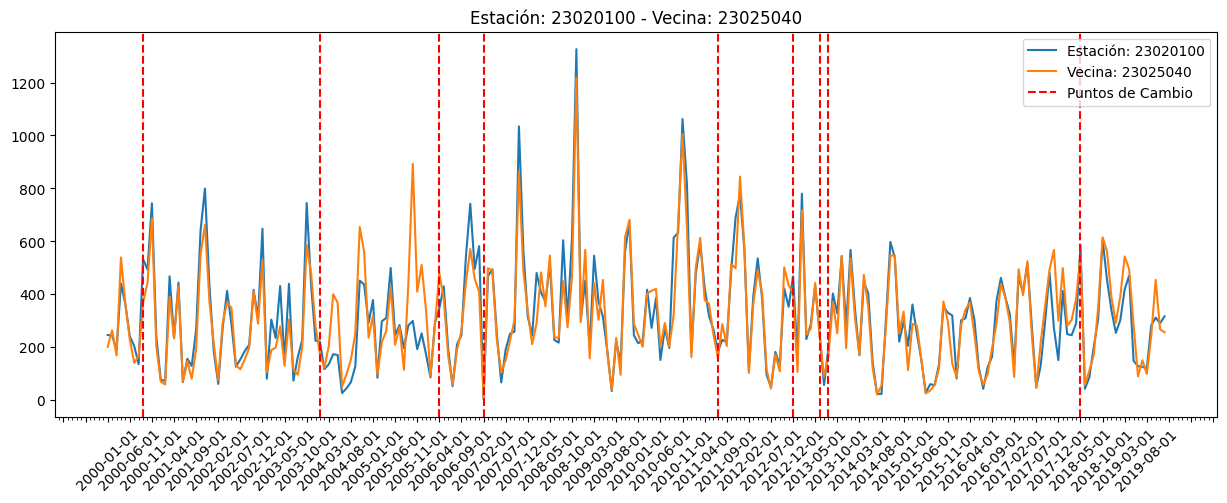

In [84]:
for zona in lista_zonas:
    print('Zona:',zona)
    path_zone = path+zona

    # leemos el archivo de estaciones vecinas
    neighboring_station_df = pd.read_csv(f'../datos/estaciones_vecinas_{zona}.csv')
    neighboring_station_df = neighboring_station_df.astype({'Estación': str})

    # shutil.rmtree(f'../datos/incrementos_anuales/{zona}/', ignore_errors=True)
    # path_output = f'../datos/incrementos_anuales/{zona}/'
    # os.makedirs(path_output)

    for file in os.listdir(path_zone):
        station = file.split('.')[0]

        # Guardamos los vecinos de cada estacion en la variable neighbors, esto se encuentra en la columnas Vecinas
        neighbors = json.loads(neighboring_station_df[neighboring_station_df["Estación"] == station]["Vecinas"].values[0])

        if neighbors != []:
            print('Estacion:', station, 'Vecinas:', neighbors)
            df = pd.read_csv(path_zone+'/'+file)
            change_points = pd.read_csv(f'../salidas/{zona}/{station}/worsley/change_points.csv')
            month = pd.merge(change_points, oni, left_on=['Punto de Cambio', 'Mes'], right_on=['Year', 'month'], how='left')

            # filtramos cuales puntos de cambio no coinciden con los fenomenos del niño o la niña y los dejamos en el dataframe
            month = month[(month["nino"] == 0) & (month["nina"] == 0)]

            if month.shape[0] > 0:
                print(f'Estación: {station} - Vecinas: {neighbors}')
                print('Punto de cambio no coincide con fenomeno del niño o la niña:')

                # Buscamos la estacion vecina con el menor valor de la raiz del error cuadratico medio
                min_RMSE = 1000000
                min_neighbor = ''
                min_neighbor_df = pd.DataFrame()

                for neighbor in neighbors:
                    print(f'Estación: {station} - Vecina: {neighbor}')
                    df_neighbor = pd.read_csv(f'{path_zone}/{neighbor}.csv')
                    print(month)
                    print(df.head(5))

                    # Aplicamos la formula de la rais del error cuadratico medio entre la estacion y la vecina
                    RMSE = np.sqrt(np.mean((df['Precipitación_imputada'] - df_neighbor['Precipitación_imputada']) ** 2))

                    if RMSE < min_RMSE:
                        min_RMSE = RMSE
                        min_neighbor = neighbor
                        min_neighbor_df = df_neighbor

                df_neighbor = min_neighbor_df
                neighbor = min_neighbor

                # tenemos los meses en cadena de texto, los pasamos a numero para  unirlos con el Año y generar fechas
                month['month_number'] = pd.to_datetime(month['Mes'], format='%B').dt.month
                month['Fecha'] = pd.to_datetime(month['Punto de Cambio'].astype(str) + '-' + month['month_number'].astype(str), format='%Y-%m')
                # eliminamos la parte de time y dejar solo la fecha, al igual que la de al columna de fecha de la estacion formato '%Y-%m-%d'
                month['Fecha'] = month['Fecha'].dt.strftime('%Y-%m-%d')

                # Graficamos la serie de tiempo de la estacion y la vecina
                # graficamos lineas verticales en los puntos de cambio
                plt.figure(figsize=(15, 5))
                plt.plot(df['Fecha'], df['Precipitación_imputada'])
                plt.plot(df_neighbor['Fecha'], df_neighbor['Precipitación_imputada'])
                
                for i in range(month.shape[0]):
                    plt.axvline(x=month.iloc[i]['Fecha'], color='r', linestyle='--')
                plt.title(f'Estación: {station} - Vecina: {neighbor}')
                # giramos las fechas para que se vean mejor y mostramos una cada 5
                plt.xticks(rotation=45)
                plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
                plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
                plt.legend([f'Estación: {station}', f'Vecina: {neighbor}', 'Puntos de Cambio'])
                plt.show()
            # df = df.set_index('Fecha')
            # df = df.resample('M').mean()
            # df = df.dropna()
            # df = df[df.index.year >= 1950]
            # df = df[df.index.year <= 2019]
            # df = df.reset_index()

            # df = df.merge(oni, left_on='Fecha', right_on='Year', how='left')
            # df = df.drop(columns=['Year', 'month', 'month_number'])
            # df = df.dropna()

            # df['nino'] = df['nino'].astype(int)
            # df['nina'] = df['nina'].astype(int)

            # df.to_csv(path + zona + '.csv', index=False, sep=';')
            break